In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

torch.manual_seed(111)

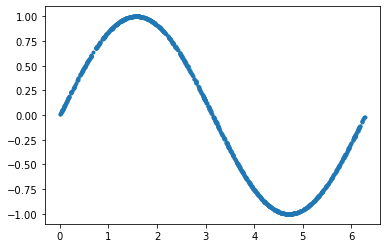

In [2]:
# Create artificial training data

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) #Random x1 values
train_data[:, 1] = torch.sin(train_data[:, 0]) #x2 = sin(x1)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [3]:
# Create PyTorch data loader

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [4]:
# Implement the discriminator
# Takes data points (x1,x2) and determines if it comes from real or "fake" data

class Discriminator(nn.Module):
    def __init__(self): #Initialize the discriminator
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), # 2 inputs (x1,x2) connecting to 256 hidden nodes
            nn.ReLU(), # first activation function is ReLU
            nn.Dropout(0.3), # use dropout to avoid overfitting
            nn.Linear(256, 128), # 2nd hidden layer has 128 nodes
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3),
            nn.Linear(128, 64), # 3rd hidden layer has 64 nodes
            nn.ReLU(), # ReLU activation
            nn.Dropout(0.3),
            nn.Linear(64, 1), # single output
            nn.Sigmoid(), # sigmoid activation to represent a probability
        )

    def forward(self, x): #Describe how the model is calculated (for us no other processing required beyond the neural network)
        output = self.model(x)
        return output
    
discriminator = Discriminator() #Instantiate the Discriminator

In [5]:
# Implement the generator
# Takes latent data points (z1,z2) to try to generate new data (x1,x2)

class Generator(nn.Module):
    def __init__(self): #Initialize the generator
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16), # 2 inputs (z1,z2) connecting to 16 hidden nodes
            nn.ReLU(), # first activation function is ReLU
            nn.Linear(16, 32), # 2nd hidden layer has 32 nodes
            nn.ReLU(), # ReLU activation
            nn.Linear(32, 2), # 2 outputs (x1,x2)
        )

    def forward(self, x): #Describe how the model is calculated (for us no other processing required beyond the neural network)
        output = self.model(x)
        return output

generator = Generator() #Instantiate the Generator

Epoch: 0 Loss D.: 0.21308737993240356
Epoch: 0 Loss G.: 1.7989580631256104
Epoch: 10 Loss D.: 0.6099680662155151
Epoch: 10 Loss G.: 0.907738447189331
Epoch: 20 Loss D.: 0.6200630068778992
Epoch: 20 Loss G.: 0.9532098770141602
Epoch: 30 Loss D.: 0.6286339163780212
Epoch: 30 Loss G.: 0.9837956428527832
Epoch: 40 Loss D.: 0.7340888381004333
Epoch: 40 Loss G.: 0.8471784591674805
Epoch: 50 Loss D.: 0.6541728377342224
Epoch: 50 Loss G.: 0.7553777098655701
Epoch: 60 Loss D.: 0.6983423829078674
Epoch: 60 Loss G.: 0.7128036618232727
Epoch: 70 Loss D.: 0.6756089329719543
Epoch: 70 Loss G.: 0.7302926778793335
Epoch: 80 Loss D.: 0.6582827568054199
Epoch: 80 Loss G.: 0.7085089683532715
Epoch: 90 Loss D.: 0.6711112260818481
Epoch: 90 Loss G.: 0.6342720985412598
Epoch: 100 Loss D.: 0.6668202877044678
Epoch: 100 Loss G.: 0.8669310808181763
Epoch: 110 Loss D.: 0.6317551136016846
Epoch: 110 Loss G.: 0.8675606846809387
Epoch: 120 Loss D.: 0.6917753219604492
Epoch: 120 Loss G.: 0.7788307666778564
Epoch: 1

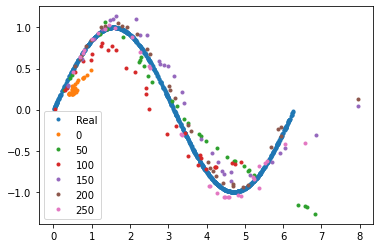

In [6]:
# Train the models
plt.plot(train_data[:, 0], train_data[:, 1], ".",label="Real")

# Set parameters
lr = 0.001 #learning rate
num_epochs = 300 #number of epochs
loss_function = nn.BCELoss() #use binary cross-entropy for loss function
# Binary cross-entropy is clearly suitable for the discriminatory, and use use the discriminator to evaluate our generator

# Set optimizers
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

# Implement a training loop
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1)) # Create labels for the real data
        latent_space_samples = torch.randn((batch_size, 2)) # Sample the latent space (z1,z2)
        generated_samples = generator(latent_space_samples) # Generate samples from (z1,z2)
        generated_samples_labels = torch.zeros((batch_size, 1)) # Create labels for generated data
        all_samples = torch.cat((real_samples, generated_samples)) # Concatenate data together
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels) # Concatenate labels together
        )

        # Training the discriminator
        discriminator.zero_grad() # In PyTorch you need to run this first to avoid accumulating gradients
        output_discriminator = discriminator(all_samples) # Compute the output of the discriminator
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels) # Compute the loss on the discriminator
        loss_discriminator.backward() # Compute the gradients
        optimizer_discriminator.step() # Update the weights of the discriminator

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2)) # Prepare new latent data to train the generator

        # Training the generator
        generator.zero_grad() # In PyTorch you need to run this first to avoid accumulating gradients
        generated_samples = generator(latent_space_samples) # Compute the output of the generator
        output_discriminator_generated = discriminator(generated_samples) # Evaluate these samples in the discriminator
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels # Compute the loss on the discriminators
        )
        loss_generator.backward() # Compute the gradients
        optimizer_generator.step() # Update the weights of the discriminator

        # Show losses
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            if epoch % 50 == 0: #Plot some intermediate generators
                generated_samples = generated_samples.detach() # Needed just to pull the data into necessary format
                plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".",label=str(epoch)) # Visualize the generated data
                plt.legend()
            

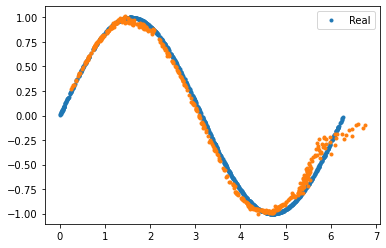

In [7]:
# Check the samples generated by the GAN
plt.plot(train_data[:, 0], train_data[:, 1], ".",label="Real")

latent_space_samples = torch.randn(500, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach() #Needed just to pull the data into necessary format
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.legend()